# 3D meshes of facial expression

Camille Renner, Lionel Desarzens, Hadrien Marcellin, Christophe Ecabert

## 1. Dependencies

*Matplotlib* do not cope well with large scale 3D data visualization. This can be overcomed by the use of `mayavi` package (*build on top of OpenGL pipeline*). It can be installed on your machine with the following commands (based on [#473](https://github.com/enthought/mayavi/issues/473#issuecomment-352033311)):

```
$ conda install -c clinicalgraphics vtk=7.1.1
$ pip install git+https://github.com/enthought/pyface.git
$ pip install git+https://github.com/enthought/traitsui.git
$ pip install git+https://github.com/enthought/mayavi.git
```

In order to use it in a `jupyter` notebook, some extension need to be installed. The command listed below will do it:

```
$ jupyter nbextension install --py mayavi --user
```

In case this note book needs to be relaunched, the data can be temporarily found [here](https://drive.switch.ch/index.php/s/A7VpGHxRdBqglkJ)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import platform
from utils import *
from mesh import *
from deformation import *
import numpy as np
import os
from sklearn import preprocessing, decomposition, neighbors, cluster
from scipy import sparse
# Mayavi stuff, can be a bit tricky on OSX
# OSX: x3d interactive backend but still buggy
# Linux: png Offscreen rendering since x3d backend schrinks when plotted
backend = 'x3d' if platform.system() == 'Darwin' else 'png'
from mayavi import mlab
mlab.init_notebook(backend, local=False)

plt.rcParams['figure.figsize'] = (17, 5)

# Base folder where data are located, user-specific
data_folder = '../data'

Notebook initialized with png backend.


## 2. Introduction

Over the last decade, the computer vision community has shown an increasing interest for 3D data. This has been possible due to the democratisation of depth sensors such as Kinect. For this reason, in the scope of this project, we will study how deformation, such as facial expression, can be transferred across 3D meshes.

The work has been split into two parts :

- Spectral clustering, is it possible to define clusters that categorize facial expressions as well as ethnicity ?
- Graph Signal Processing, can facial expression (i.e. Mouth open, raised eyebrows, …) be reproduced, using different number of anchors ?

Two datasets are used in order to do so, one being avaible for academic research called *FaceWarehouse* and one collected here at *EPFL*. Both datasets are composed of meshes of people with various facial expressions. They have the following properties:

- FaceWarehouse: 150 people, 47 expressions, mainly asian people
- EPFL: 120 people, mainly caucasian people.

Every meshes share the same topology since there are registered (i.e. densely aligned).

## 3. Data Analysis

This section will investigate if it possible to recover cluster in the data that correspond to the various expressions and ethnies within the datasets.

### 3.1 Loading Train and Test sets

The complete dataset of meshes contains 46 differents faces for 150 persons, mainly asians. In order to classify or find the different clusters, a train and a test sets are created with a ratio of 75% of the samples for the train set and the rest used for the test set.

In [2]:
folder_path = os.path.join(data_folder, 'FWMesh/')
individuals, individuals_test = utils.load_set(0.75,folder_path)

A Jupyter Widget

A Jupyter Widget

### 3.2 Classification approach - Supervised
(Using Subject's neutral face)

In this section, we aim to learn 15 different faces and then being able to classify a face from a new person. The expressive face is therefore compared to the neutral face of each subject.

#### 3.2.1 Extracting features for both train and test sets

A feature matrix is created. Face[0] of an individual corresponds to its neutral face whereas the faces from index 1 until index 15 are facial expressions that results from movements around the eyes. To reduce the computational load, only the 15 first faces are considered.

The difference between the expressive faces and the neutral one is calculated for each node of the meshes in the three dimensions x, y and z. This error per node per dimension build the feature matrix.

The length of this matrix corresponds to the length of the train set multiplied by the number of expressive face, in our case $112*14$.

In [3]:
nb_face = 15
expression_label, features = utils.construct_features_matrix(individuals, nb_face)
expression_label_test, features_test = utils.construct_features_matrix(individuals_test, nb_face)

A Jupyter Widget

A Jupyter Widget

#### 3.2.2 Compute Laplacian, eigenvectors and eigenvalues.

Compute Distances


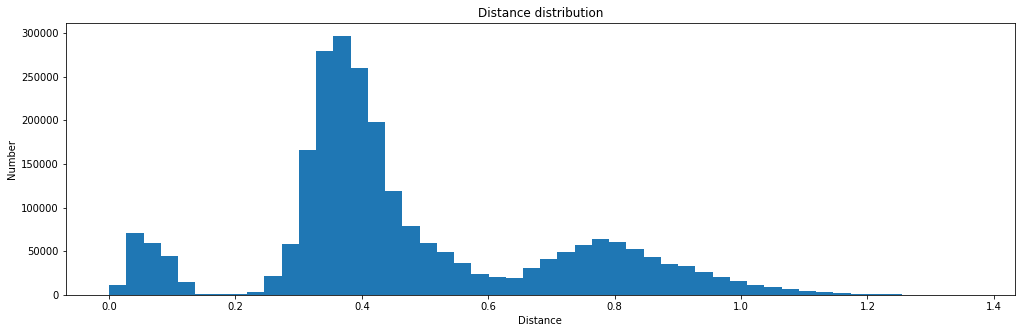

A Jupyter Widget


Compute Laplacian
Compute Eigenvalues/vectors


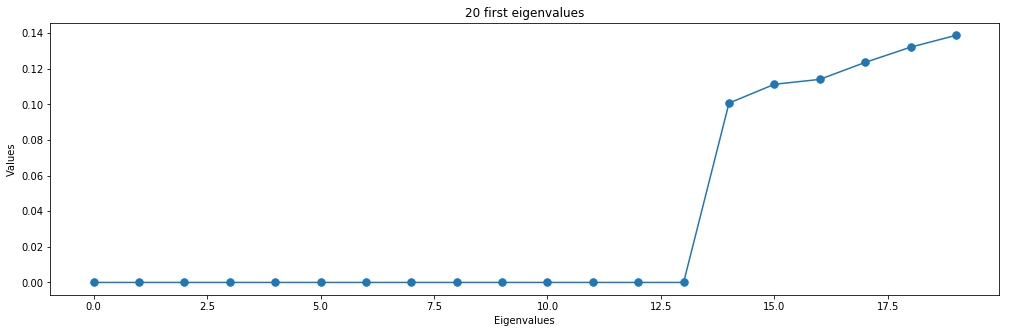

In [4]:
eigenvalues, eigenvectors = utils.compute_laplacian(features, 
                                                    nb_neighbours = 10,
                                                    distance_metric = 'euclidean',
                                                    nb_eigen = 20, 
                                                    verbose=1)

Calculating the eigenvalues enables to find the number of cluster inherent of the features. Here, we find 14 eigenvalues with values equals to zero and therefore it matches the 14 different expressive faces.

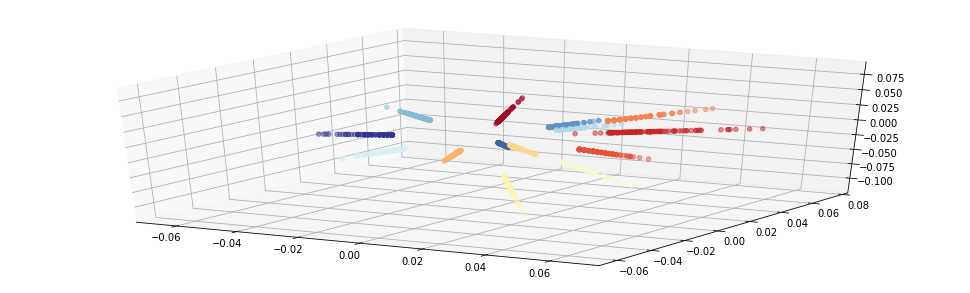

In [5]:
x = eigenvectors[:,3]
y = eigenvectors[:,13]
z = eigenvectors[:,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=expression_label, cmap='RdYlBu', alpha=0.5);

With the plot above, we can see that similar expressions form 14 clusters clearly separated, especially when using the eigenvectors as coordinates.

#### 3.2.3 Machine Learning: kNN

In [6]:
# Train classifier
n_neighbors = nb_face
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(features, expression_label)
# Test
Z = clf.predict(features_test)
# Check performance
error_clf = np.count_nonzero(Z-expression_label_test)
print('Number of miss-classified test samples %d' % error_clf)

Number of miss-classified test samples 0


### 3.3 Clustering approach - Unsupervised

#### 3.3.1 Expression clustering

The goal here it to suppose that we do not know the number of different facial expressions. This number will be found with the number of eigenvalues equals to zero and then a classifier is trained in order to regroup identical facial expressions.

In this section, the same feature matrix as above is used. Nevertheless, the eigenvectors are used as features for the machine learning part. This choice reduce the computational load while keeping discriminant informations.

##### 3.3.1.1 Machine Learning: KMeans

First, we train the classifier.

In [7]:
nb_cluster = len(eigenvalues[eigenvalues < 0.02])
cluster_features = cluster.KMeans(nb_cluster).fit(eigenvectors[:,:nb_cluster])

##### 3.3.1.2 Compute Laplacian for the test set

Compute Distances


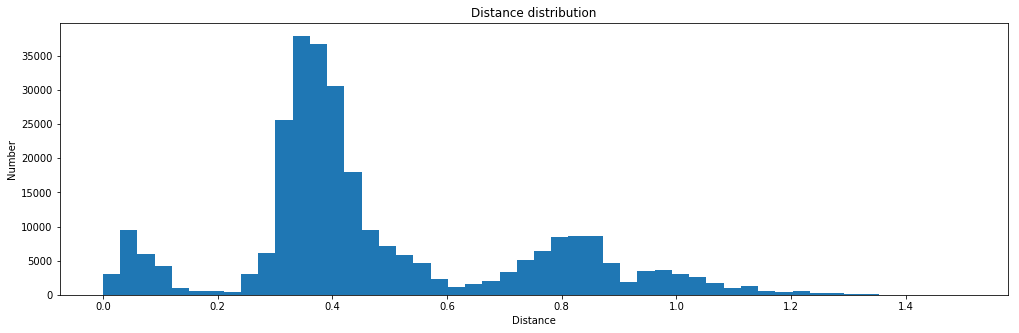

A Jupyter Widget


Compute Laplacian
Compute Eigenvalues/vectors


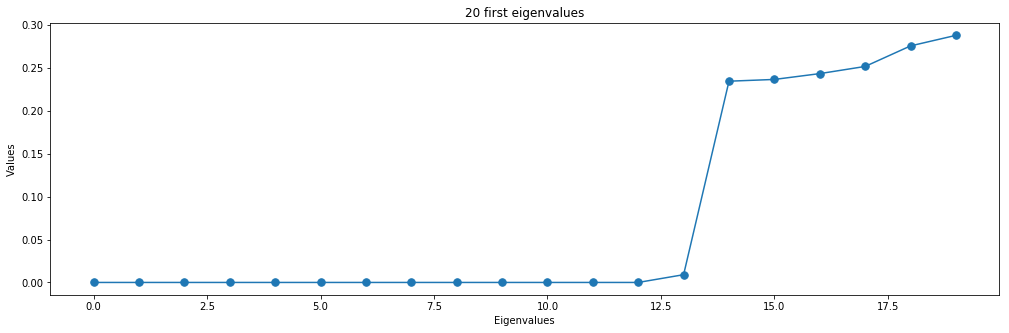

In [28]:
eigenvalues_test, eigenvectors_test = utils.compute_laplacian(features_test,
                                                              nb_neighbours = 10, 
                                                              distance_metric = 'euclidean',
                                                              nb_eigen = 20, 
                                                              verbose=1)

Again, we can see that the eigenvalues fit the number of clusters.

(array([ 38.,  38.,  38.,  38.,   0.,  38.,   0.,  38.,   0.,  76.,  38.,
         38.,  76.,  76.]),
 array([  0.        ,   0.85714286,   1.71428571,   2.57142857,
          3.42857143,   4.28571429,   5.14285714,   6.        ,
          6.85714286,   7.71428571,   8.57142857,   9.42857143,
         10.28571429,  11.14285714,  12.        ]),
 <a list of 14 Patch objects>)

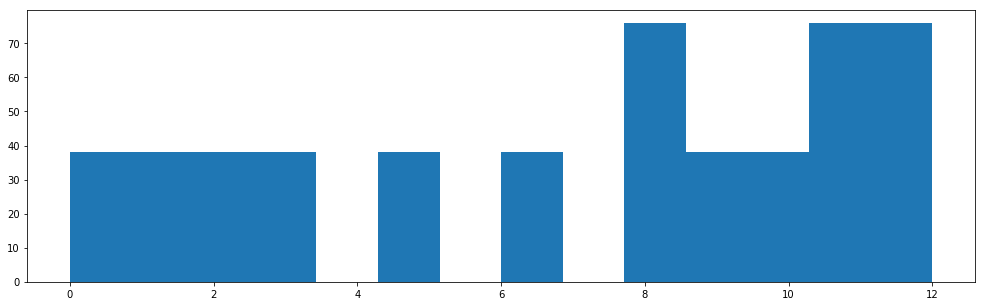

In [29]:
prediction = cluster_features.predict(eigenvectors_test[:,:nb_cluster])
plt.hist(prediction, bins=14)

In this plot, we can observe that the model, on average, can correctly aggregate identical facial expressions. Nevertheless, it fails to recognize three expression and mixes the meshes with another face which might be really close of the other one.

### 3.3.2 Ethnies clustering

Now, another dataset containing caucasian faces is added. We will see if a kMeans classifier is able to differentiate between ethnies.

In [30]:
folder_path = os.path.join(data_folder, 'LTS5Mesh/')
caucasian, caucasian_test = utils.load_set(0.75,folder_path)
# Check
totals = list(individuals)
totals.extend(caucasian)
totals_test = list(individuals_test)
totals_test.extend(caucasian_test)
len(totals[113])

A Jupyter Widget

A Jupyter Widget

1

The caucasian dataset contains 120 samples. With the split ratio between train and test set, 90 caucasian samples are assigned to the train set whereas 30 are in the test set.

##### 3.3.2.1 Construct features matrix

In order to compare the two ethnies, only the neutral face is used.

In [31]:
nb_face = 0
expression_label, neutrals = utils.construct_features_matrix(totals, nb_face)
expression_label_test, neutrals_test = utils.construct_features_matrix(totals_test, nb_face)

A Jupyter Widget

A Jupyter Widget

##### 3.3.2.2 Compute Laplacian for both sets

Compute Distances


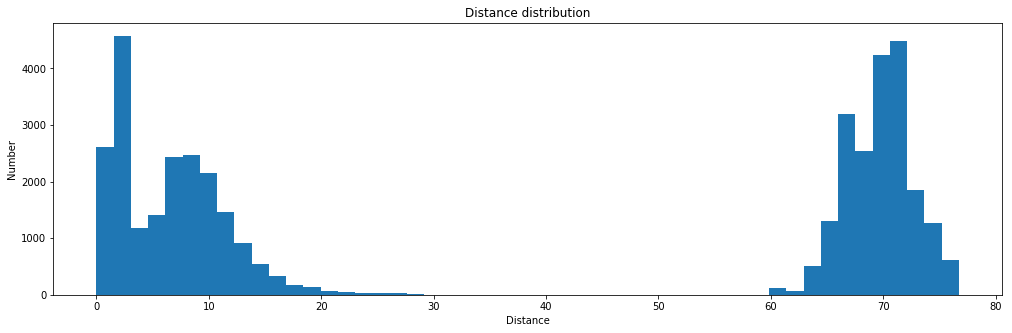

A Jupyter Widget


Compute Laplacian
Compute Eigenvalues/vectors


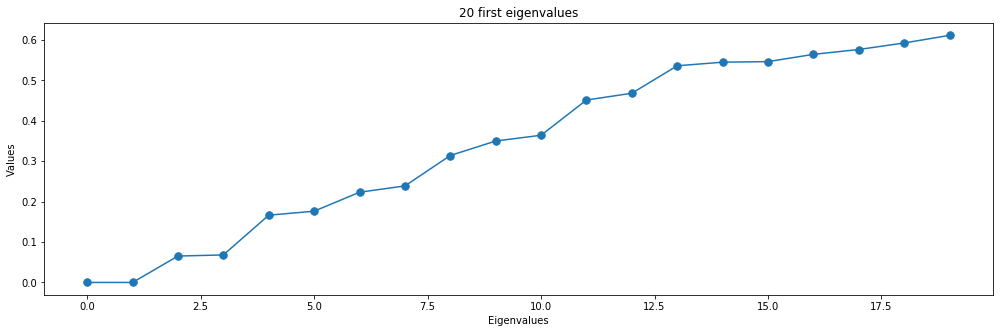

In [32]:
eigenvalues_neutral, eigenvectors_neutral = utils.compute_laplacian(neutrals, 
                                                                    nb_neighbours = 10, 
                                                                    distance_metric = 'euclidean', 
                                                                    nb_eigen = 20, 
                                                                    verbose=1)

Compute Distances


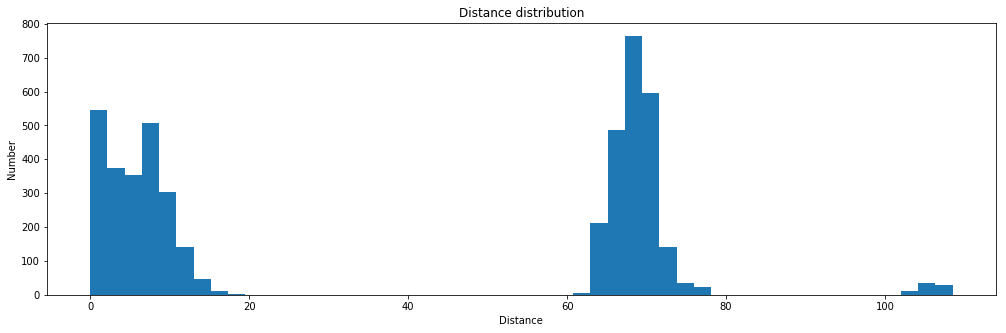

A Jupyter Widget


Compute Laplacian
Compute Eigenvalues/vectors


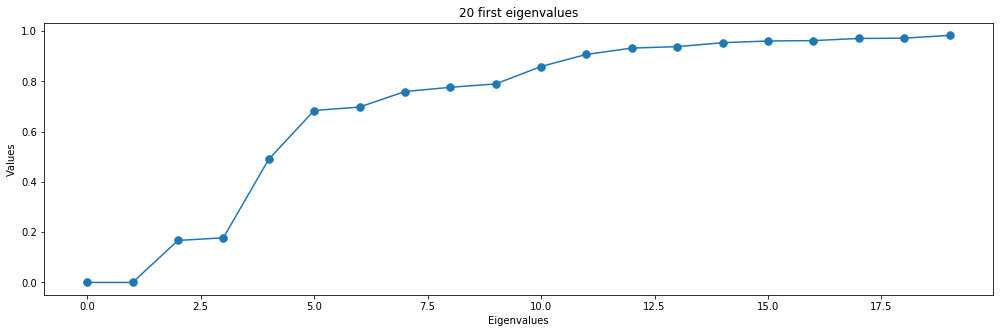

In [37]:
nb_cluster_neutral = len(eigenvalues_neutral[eigenvalues_neutral < 0.02])
cluster_features = cluster.KMeans(nb_cluster_neutral).fit(eigenvectors_neutral[:,:nb_cluster_neutral])
eigenvalues_neutral_test, eigenvectors_neutral_test = utils.compute_laplacian(neutrals_test, 
                                                                              nb_neighbours = 10,
                                                                              distance_metric = 'euclidean', 
                                                                              nb_eigen = 20, 
                                                                              verbose=1)

We can see in the plots above that in both sets, the distances and the eigenvalues indicate that we have two clusters. From this point we could be confident that our model will be able to differentiate between ethnies.

##### 3.3.2.3 Machine learning: K Means

(array([ 38.,  30.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

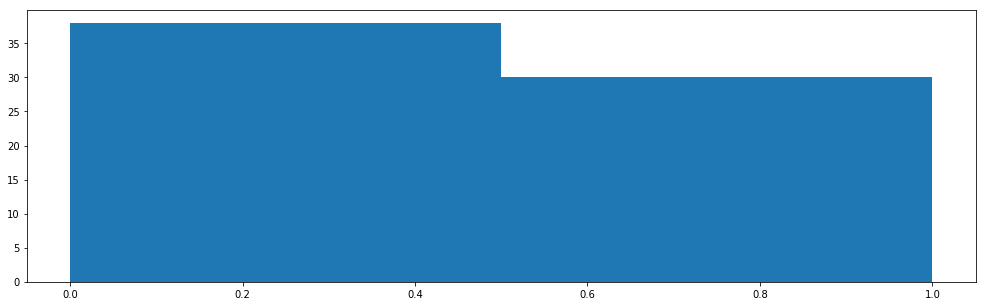

In [38]:
prediction = cluster_features.predict(eigenvectors_neutral_test[:,:nb_cluster_neutral])
plt.hist(prediction, bins=nb_cluster_neutral)

Here, we can observe that the model is able to differentiate the two ethnies, asians and caucasians. Indeed, we have in our group the 30 samples that are caucasians and the rest that corresponds to the number of asians in the test set.

### 3.3.3 Learn with a common neutral averaged face

So far the approach used is person specific (i.e. euch neutral expression is removed from the expression), however is it possible to still recover expression without being specific to each identity ?

In this approach the average neutral face will be removed from each specific expressions and see if it leads to something.

In [39]:
folder_path = os.path.join(data_folder, 'FWMesh/')
tri = utils.load_triangulation(os.path.join(data_folder, 'FWTri/fw_triangulation.tri'))

#### 3.3.3.1 Create average neutral face

In [40]:
neutrals = [ind[0] for ind in individuals]
neutrals = np.array(neutrals)
neutrals_avg = neutrals.mean(0)


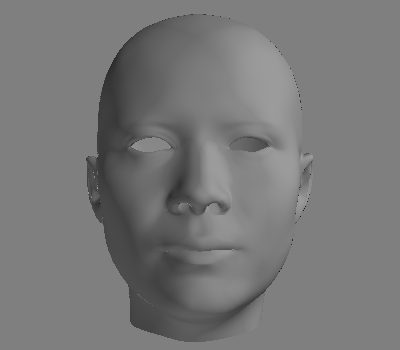

In [41]:
mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh_avg = mlab.triangular_mesh(neutrals_avg[:,0], neutrals_avg[:,1], neutrals_avg[:,2], tri, color=color)
mlab.view(0,0)
trimesh_avg

In order to have a more precise analysis, the features matrix is reduced to only meaningful nodes (ex : remove nodes related to the back of the head). Therefore, we keep the nodes that have non-zero values when computing the vectors of difference between faces and neutral face. We know for sure the vector of difference between faces and averaged neutral face will be noisy.

"index_err" contains all the indices of these nodes.


In [42]:
nb_face=15 

for j,face in enumerate(individuals[0][1:nb_face]):
        if j == 0:
            features_err = face.reshape(1,-1) - individuals[0][0].reshape(1,-1)
        else:
            err = face.reshape(1,-1) - individuals[0][0].reshape(1,-1)
            features_err = np.vstack((features_err, err))

features_err.sum(0)
index_err = [i for i, j in enumerate(features_err.sum(0)) if j != 0]

#### 3.3.3.2 Compute features for train and test sets

Here we compute the features matrices for train set and test set using the neutral averaged face and the indices of the meshes we selected above.


In [44]:
features_avg = []

for i,ind in enumerate(tqdm_notebook((individuals),desc = 'Built Features')):
    for j,face in enumerate(ind[1:nb_face]):
        if (i == 0 and j == 0):
            features_avg = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
        else:
            err = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
            features_avg = np.vstack((features_avg, err))

A Jupyter Widget

In [45]:
for i,ind in enumerate(tqdm_notebook((individuals_test),desc = 'Built Features')):
    for j,face in enumerate(ind[1:nb_face]):
        if (i == 0 and j == 0):
            features_avg_test = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
        else:
            err = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
            features_avg_test = np.vstack((features_avg_test, err))

A Jupyter Widget

#### 3.3.3.3 Compute Laplacian

Compute Distances


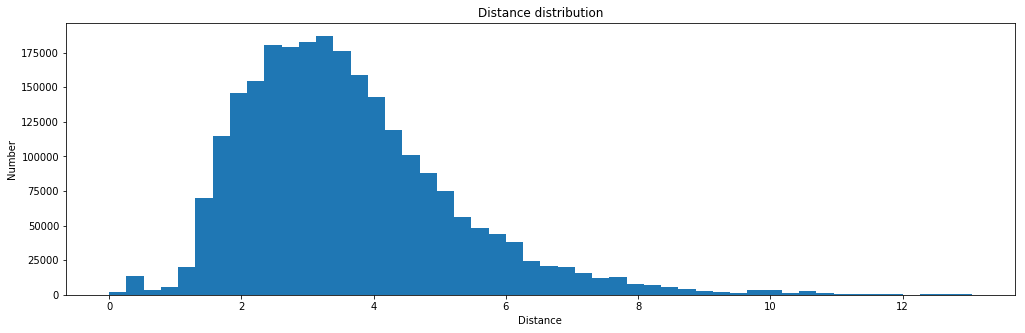

A Jupyter Widget


Compute Laplacian
Compute Eigenvalues/vectors


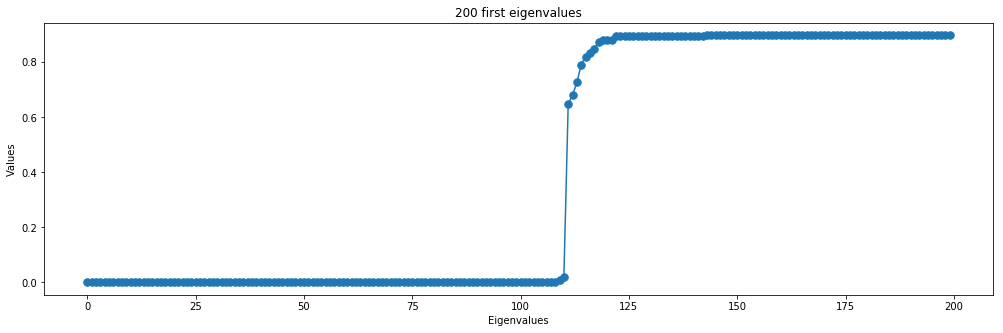

In [46]:
eigenvalues_avg, eigenvectors_avg = utils.compute_laplacian(features_avg, 
                                                            nb_neighbours = 10, 
                                                            distance_metric = 'euclidean', 
                                                            nb_eigen = 200,
                                                            verbose=1)

We see from the graph of the eigenvalues we have approximatively 115 zero eigenvalues meaning we have 115 connected subgraphs, corresponding, we believe, to the 113 individuals from the train set. Thus, we conclude the use of the averaged neutral face is not convincing since it does not allow a clustering of the different kind of faces.

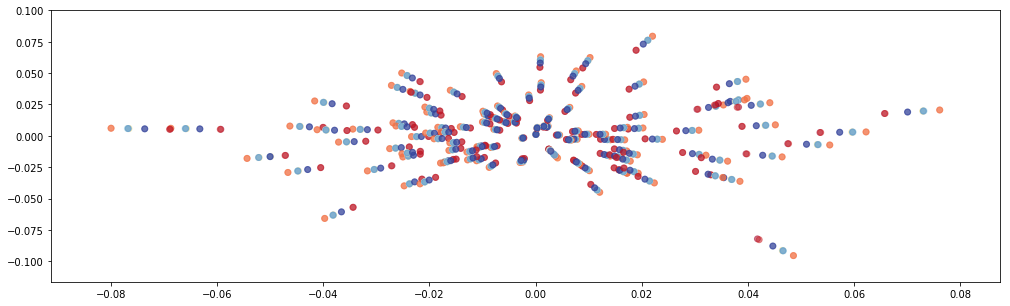

In [47]:
expression_label = [j for i in range(0,len(individuals)) for j in range(1,nb_face)]
x = eigenvectors_avg[:, 3]
y = eigenvectors_avg[:, 2]

fig = plt.figure()
plt.scatter(x, y, c=expression_label, cmap='RdYlBu', alpha=0.5);

On this graph we see clustering of dots with different colors that may be all kind of faces grouped by individuals.

## 4. Graph-based deformation learning

In this section, the deformation between different facial expressions will be investigated under two formulations:

- Deformation field
- Constrainted reconstruction

### 4.1 Deformation field

Every meshes in the dataset are densely registered, all the vertices have the same semantics. Therefore the targeted surface $\boldsymbol{x}^t$ can be defined with respect of the source $\boldsymbol{x}^s$ and a deformation field $\boldsymbol{d}$.

$$ \boldsymbol{x}^t = \boldsymbol{x}^s + \boldsymbol{d} $$

The goal is to estimate the deformation field only using a sparse subset of $K$ target's vertices. The deformation learning can be formulated using graph-based tool as follow:

$$ \boldsymbol{d}^*_i = argmin \quad \left|\left| M \left(\boldsymbol{x}_i^s + \boldsymbol{d}_i \right) - \boldsymbol{x}_i^t \right|\right|_2^2 + \alpha \boldsymbol{d}_i^{\top}\boldsymbol{L} \boldsymbol{d}_i $$

where:

- $\boldsymbol{x}_i^s \in \mathbb{R}^{N \times 1}, i \in \{x,y,z \}$ the source's component
- $\boldsymbol{x}_i^s \in \mathbb{R}^{K \times 1}, i \in \{x,y,z \}$ the target's component
- $\boldsymbol{M} \in \mathbb{R}^{K \times M}$ a selection operator
- $\boldsymbol{L} \in \mathbb{R}^{N \times N}$ the laplacian operator
- $\boldsymbol{d}_i \in \mathbb{R}^{N \times 1}, i \in \{x,y,z\}$ the deformation field's component
- $\alpha$, the regularization factor balancing the two terms

#### 4.1.1. Anchor selection

In order to have constraints over all surface's points, the anchors are selected using a downsampled version of the original mesh. The sources is decimated by a factor of $20$ using algorithm based on [Surface Simplification Using Quadric Error Metrics](https://www.ri.cmu.edu/pub_files/pub2/garland_michael_1997_1/garland_michael_1997_1.pdf).
The selection operator is build from the anchor's indexes $a_i \in C$ computed previously. The operator $\boldsymbol{M}$ is defined as:

$$ \boldsymbol{M}_{ij} = \begin{cases} 1 & \mbox{if } j \in C \\ 0 & otherwise \end{cases} $$

In [48]:
# Load source + target meshes + anchors
tri = utils.load_triangulation(os.path.join(data_folder, 'FWTri/fw_triangulation.tri'))
meshes = utils.load_meshes(os.path.join(data_folder, 'FWMesh/115_shape.bs'), [0, 22])
anchors = utils.load_anchor_point(os.path.join(data_folder, 'anchors.cfg'))

In [49]:
# Create mesh instances for source and target surface
mesh_xs = Mesh(meshes[0], tri)
mesh_xt = Mesh(meshes[1], tri)
N = meshes[0].shape[0]
# Dump meshes into .obj file
mesh_xs.save('source.obj')
mesh_xt.save('target.obj')
# Define ground-truth
d_true = mesh_xt.vertex - mesh_xs.vertex
d_norm = np.linalg.norm(d_true, axis=1)


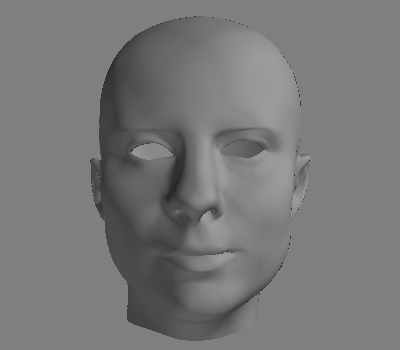

In [50]:
# Source surface
mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh_xs = mlab.triangular_mesh(mesh_xs.vertex[:,0], mesh_xs.vertex[:,1], mesh_xs.vertex[:,2], mesh_xs.tri, color=color)
mlab.view(0,0)
trimesh_xs

Figure above shows an example of $\boldsymbol{x}^s$ used as source for the deformation estimation


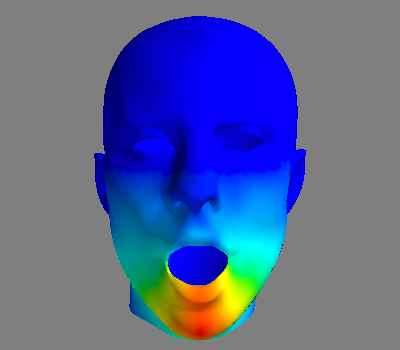

In [51]:
# Target surface, with displacment color coded (Red = large).  
mlab.clf()
trimesh_xt = mlab.triangular_mesh(mesh_xt.vertex[:,0], mesh_xt.vertex[:,1], mesh_xs.vertex[:,2], mesh_xt.tri, scalars=d_norm)
mlab.view(0, 0)
trimesh_xt

Figure above shows an example of a targetted expressions, $\boldsymbol{x}^t$, that need to be recovered. The colors represents the distance from the source, $\boldsymbol{x}^s$, which is the deformation $\boldsymbol{d}$ that needs to be estimated.

In [52]:
# 1) create selection mask
K = len(anchors)
ridx = [k for k in range(K)]
cidx = anchors
data = [1.0] * K
M = sparse.coo_matrix((data, (ridx, cidx)), shape=(K, N), dtype=np.float32)
# 2) Comptue laplacian
_,_, Lap = mesh_xs.compute_laplacian('cotan')
# 3) Compute target
Xs = mesh_xs.vertex
Xt = M.dot(mesh_xt.vertex)

In [53]:
# 4) Estimate deformation field without regularization
estm_xt, d = deform_regularized_anchor(Xs, Xt, M, Lap, 0.05)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e_def = np.mean(err)
print('Mean error of %f, for %d anchors' % (e_def, K))
m = Mesh(estm_xt, tri)
m.save('deformation_field.obj')

Mean error of 0.002153, for 587 anchors



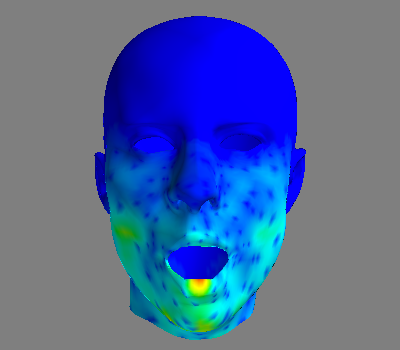

In [54]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

Figure above shows the estimated target surface. The color represents the point-to-point error between the two surfaces. The sparse blue dots on the surface can be explained by the fact that they are the vertices correspoinding to the anchor points, therefore the error at those locations is small compare to the rest of the surface. Regardings the other parts such as the top of the skull or the ears, the erros is minimum since the is not deformation in those area.

However the deformation field in the mouth region is not approximated correctly (*i.e. around the lips*) and lead to unrealistic solutions.

### 4.2 Constrainted Reconstruction

The second approach try to estimate directly the target surface $\boldsymbol{x}^t$ from a set of constraints. There are two types of constraints, the first one are related to the surface curvature and the second one are related to absolute position in space.

When applying the Laplacian operator on vertices, $(\boldsymbol{Lx})_{i} =  \frac{1}{d_i} \sum_{j \in N(i)} \left(\boldsymbol{x}_i - \boldsymbol{x}_j \right)$, it provides an estimation of the local curvature for each vertices. Therefore we can constraint the target's local curvature to be close to the source one $\boldsymbol{Lx}^t \approx \boldsymbol{Lx}^s$. Solving this problem will not gives a unique solution since the Laplacian operator is not full rank (*i.e. there is at least one eigenvalue equal to zero*). Therefore more constraints need to be added. The Laplacian is augmented with positional contraints. Finally we have:

$$ \boldsymbol{\delta}^s = \boldsymbol{Lx}^s $$

$$ \left[ \begin{array}{c} \boldsymbol{L} \\ \lambda \boldsymbol{A} \end{array} \right]\boldsymbol{x}^t = \left[ \begin{array}{c} \boldsymbol{\delta}^s \\ \lambda \boldsymbol{C}^t \end{array} \right] $$

where

$$ \boldsymbol{A}_{ij} = \begin{cases} 1 & \mbox{if } j \in C \\ 0 & otherwise \end{cases} $$
$$ \boldsymbol{C}^t_{(0... k)} = \boldsymbol{x}^t_k,  k \in C $$

[ref](https://people.eecs.berkeley.edu/~jrs/meshpapers/Sorkine.pdf)

In [55]:
# Reuse the same anchors for fare comparison, comparison with subset will be conducted below
anchorsIdx = anchors
anchors_pts = mesh_xt.vertex[anchorsIdx, :]
# Deform
estm_xt = deform_mesh(mesh_xs, anchors_pts, anchorsIdx, 1.0)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e = np.mean(err)
print('Mean error: %f, for %d anchors' % (e, len(anchorsIdx)))

Mean error: 0.001216, for 587 anchors



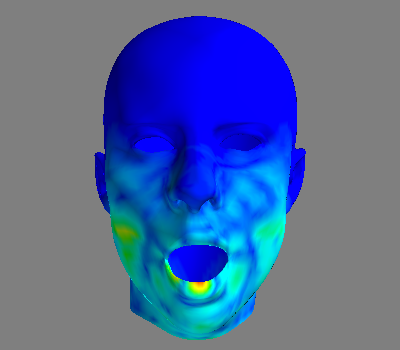

In [56]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

Figure above shows the result with positional and curvature constraints. Using the same set of anchors the average per-vertex error is smaller and the deformation is more realistic than previously shown.

In [57]:
# Analyse error with respect to the number of anchor points selected. What happen if we take only a subset of
# the original anchor set ?
err_step = []
estm_step = []
n_step = 11
for k in range(1, n_step):
    idx = np.random.permutation(anchors)
    n_idx = k * int(len(anchors) / n_step)
    anchorsIdx = idx[0:n_idx]
    anchors_pts = mesh_xt.vertex[anchorsIdx, :]
    # Deform
    estm_xt = deform_mesh(mesh_xs, anchors_pts, anchorsIdx, 1.0)
    estm_step.append(estm_xt)
    # Error
    err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
    e = np.mean(err)
    print('Mean error: %f, for %d anchors' % (e, len(anchorsIdx)))
    err_step.append(e)

Mean error: 0.007499, for 53 anchors
Mean error: 0.005030, for 106 anchors
Mean error: 0.003265, for 159 anchors
Mean error: 0.002292, for 212 anchors
Mean error: 0.002119, for 265 anchors
Mean error: 0.002074, for 318 anchors
Mean error: 0.001570, for 371 anchors
Mean error: 0.001438, for 424 anchors
Mean error: 0.001442, for 477 anchors
Mean error: 0.001281, for 530 anchors


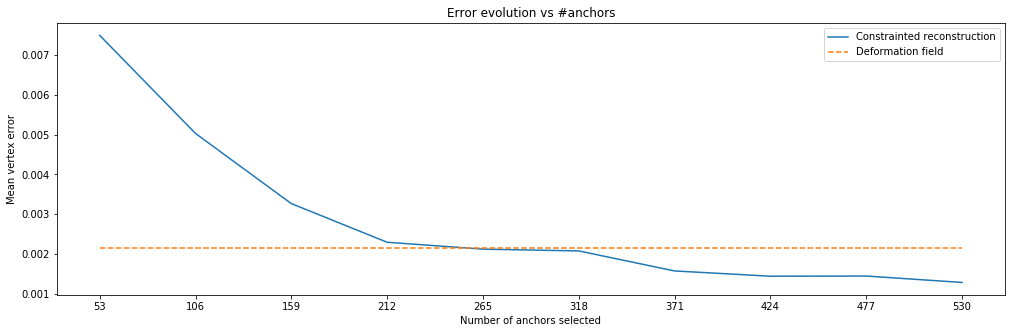

In [58]:
# Error comparisons
plt.plot(err_step)
plt.title('Error evolution vs #anchors')
plt.ylabel('Mean vertex error')
plt.xlabel('Number of anchors selected')
x = [k * int(len(anchors) / n_step) for k in range(1, n_step)]
xi = [k for k in range(0, n_step - 1)]
plt.xticks(xi, x)
# Deformation field
plt.plot([0, xi[-1]],[e_def, e_def], '--')
# Legend
plt.legend(['Constrainted reconstruction', 'Deformation field'])
plt.show()

This plot shows the evolution of the average per-vertex error when the number of anchors is augemented. The deformation field estimated earlier is used as baseline for comparison (*i.e. estimated with all anchors !*).

It shows that the number of anchors can be reduced to achieve similar performance in term of error while keeping a realistic solution. The solution recovered with 318 anchor points is displayed in the next figure.



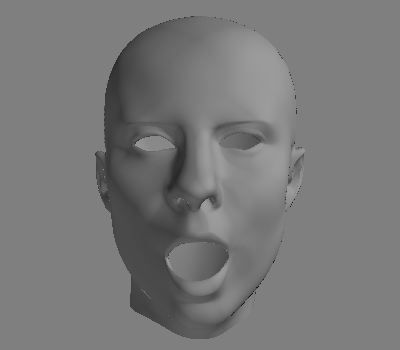

In [59]:
mlab.clf()
trimesh_xt_estm_5 = mlab.triangular_mesh(estm_step[5][:,0], estm_step[5][:,1], estm_step[5][:,2], mesh_xt.tri, color=(0.5, 0.5, 0.5))
mlab.view(0, 0)
trimesh_xt_estm_5

## 5. Conclusions

Computing laplacians and the corresponding eigenvalues/eigenvectors on 3D facial meshes enables to correctly classify as well as cluster the different expressions and ethnies. Nevertheless, this is limited by the fact that the neutral face of each individual is needed. Indeed, with an averaged neutral face, the process did not worked anymore. Overall, these approaches were satisfying.

Regarding the expression transfer, learning directly a deformation field between the different expressions is able to capture the meaning of the expression but the estimated solution provides unrealistic shape as shown earlier. The second method (*i.e. Least-Square Mesh*) provides more accurate and realistic solution using less constraints. Moreover it has been shown that using structural constraints induced by the Laplacian operator can be helpfull in 3D geometry for various use cases.